## Hyperparameters optimization for SVC in the case of binary class (Sell, Buy)

Using SVC give slightly better results for our "model", both in-sample and out-of-sample. 

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import StratifiedKFold




In [2]:
# Get underlying prices
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [3]:
target = pd.read_csv("../data/processed/target_df.csv", index_col = 0)["target"]

In [4]:
# Get the working dataframe
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [5]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [6]:
interest_rate = wk_df["r"].values

### EDA for exp_price file

[Open report](exp_price_report.html)

In [7]:
def display_report(y_test:np.ndarray, predictions:np.ndarray)->None:
    print(classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    return

In [8]:
def plot_feature_imp(coefficients:np.ndarray[float], columns:list[str])->None:

    feature_importance = pd.DataFrame({'Feature': columns, 'Importance': np.abs(coefficients)})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
    plt.show()
    return

In [9]:
def get_params()->dict:
    C = np.logspace(-2,2,30)
    kernel = ['linear', 'poly', 'rbf', 'sigmoid']
    degree = [2,3,4,5,6,7,8]
    gamma = ["auto", "scale"]
    shrinking = [True, False]

    random_grid = {'svc__C': C,
                'svc__kernel': kernel,
                'svc__degree': degree,
                'svc__gamma': gamma,
                'svc__shrinking': shrinking, 
                'svc__random_state':[1968]
                }
    
    return random_grid

## Baseline Random Forest Classifier without new data + r

In [10]:
orig_df = ml_df[["UNDERLYING_LAST", "STRIKE", "C_LAST", "C_BID", "C_ASK", "C_IV", "C_VOLUME", "diff_date"]].copy()

In [11]:
orig_df["r"] = interest_rate

In [12]:
X_train, X_test, y_train, y_test = train_test_split(orig_df.values, target.values.flatten(), test_size=0.2, random_state=1968)

In [13]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('scaler', StandardScaler()),('svc', SVC())])

In [14]:
n_iter = 200
verbose_level = 1
n_jobs = 4
cv = StratifiedKFold(4)
random_grid = get_params()

In [15]:
# Grid search
rf_random = RandomizedSearchCV(estimator = pipe, 
                               param_distributions = random_grid, 
                               n_iter = n_iter, 
                               cv = cv, 
                               verbose=verbose_level, 
                               random_state=1968, 
                               n_jobs = n_jobs)

In [16]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 200 candidates, totalling 800 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(fill_value=0.0,
                                                            strategy='constant')),
                                             ('scaler', StandardScaler()),
                                             ('svc', SVC())]),
                   n_iter=200, n_jobs=4,
                   param_distributions={'svc__C': array([1.00000000e-02, 1.37382380e-02, 1.88739182e-02, 2.59294380e-02,
       3.56224789e-02, 4.89...
       1.61026203e+00, 2.21221629e+00, 3.03919538e+00, 4.17531894e+00,
       5.73615251e+00, 7.88046282e+00, 1.08263673e+01, 1.48735211e+01,
       2.04335972e+01, 2.80721620e+01, 3.85662042e+01, 5.29831691e+01,
       7.27895384e+01, 1.00000000e+02]),
                                        'svc__degree': [2, 3, 4, 5, 6, 7, 8],
                                        'svc__gamma': ['auto', 'scale'],
                                        'svc__kernel': ['linear', 'poly', 'rbf',
                                                        'sigmoid'],
                                        'svc__random_state': [1968],
                                        'svc__shrinking': [True, False]},
                   random_state=1968, verbose=1)

In [17]:
rf_random.best_params_

{'svc__shrinking': False,
 'svc__random_state': 1968,
 'svc__kernel': 'poly',
 'svc__gamma': 'auto',
 'svc__degree': 4,
 'svc__C': 5.736152510448681}

In [18]:
pd.DataFrame.from_dict(rf_random.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__shrinking,param_svc__random_state,param_svc__kernel,param_svc__gamma,param_svc__degree,param_svc__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
61,0.117797,0.033258,0.007451,0.001576,False,1968,poly,auto,4,5.736153,"{'svc__shrinking': False, 'svc__random_state':...",0.589641,0.585657,0.612,0.608,0.598825,0.011352,1
185,0.054245,0.012316,0.012031,0.002370,True,1968,poly,auto,7,1.172102,"{'svc__shrinking': True, 'svc__random_state': ...",0.565737,0.585657,0.640,0.596,0.596849,0.027184,2
41,0.058453,0.009415,0.018515,0.002052,True,1968,rbf,auto,6,100.0,"{'svc__shrinking': True, 'svc__random_state': ...",0.581673,0.601594,0.572,0.612,0.591817,0.015800,3
130,0.057052,0.010734,0.021635,0.003217,True,1968,rbf,scale,2,72.789538,"{'svc__shrinking': True, 'svc__random_state': ...",0.565737,0.593625,0.572,0.612,0.585841,0.018307,4
177,0.053835,0.003998,0.023870,0.000853,True,1968,rbf,scale,8,72.789538,"{'svc__shrinking': True, 'svc__random_state': ...",0.565737,0.593625,0.572,0.612,0.585841,0.018307,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.026942,0.006639,0.005969,0.000668,False,1968,sigmoid,scale,4,100.0,"{'svc__shrinking': False, 'svc__random_state':...",0.498008,0.498008,0.508,0.476,0.495004,0.011706,192
196,0.028911,0.004910,0.006333,0.000890,True,1968,sigmoid,auto,4,72.789538,"{'svc__shrinking': True, 'svc__random_state': ...",0.501992,0.501992,0.500,0.476,0.494996,0.010997,197
16,0.030380,0.005280,0.006921,0.001661,False,1968,sigmoid,scale,6,20.433597,"{'svc__shrinking': False, 'svc__random_state':...",0.498008,0.490040,0.512,0.476,0.494012,0.013036,198
171,0.037123,0.009299,0.010818,0.004661,True,1968,sigmoid,scale,6,20.433597,"{'svc__shrinking': True, 'svc__random_state': ...",0.498008,0.490040,0.512,0.476,0.494012,0.013036,198


In [19]:
best_model = rf_random.best_estimator_

In [20]:
best_model.score(X_test, y_test)

0.6055776892430279

In [21]:
predictions = best_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.66      0.41      0.50       123
           1       0.58      0.80      0.67       128

    accuracy                           0.61       251
   macro avg       0.62      0.60      0.59       251
weighted avg       0.62      0.61      0.59       251



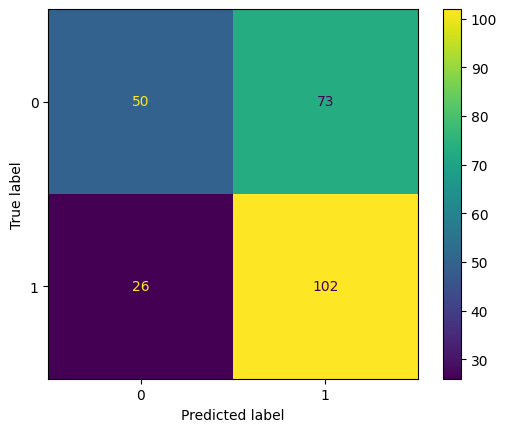

In [22]:
display_report(y_test, predictions)

### Test model

In [23]:
X_train, X_test, y_train, y_test = train_test_split(orig_df.values, target.values.flatten(), test_size=0.2, random_state=1968, shuffle=False)

In [24]:
rf_params = {k[5:]:v for k,v in rf_random.best_params_.items()} | {
 'verbose':1}

In [25]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('scaler', StandardScaler()), ('svc', SVC(**rf_params))])

In [26]:
# Fit the tuned model
pipe.fit(X_train, y_train)

[LibSVM].....................................................*
optimization finished, #iter = 53415
obj = -4925.253676, rho = 0.708761
nSV = 910, nBSV = 855
Total nSV = 910


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('svc',
                 SVC(C=5.736152510448681, degree=4, gamma='auto', kernel='poly',
                     random_state=1968, shrinking=False, verbose=1))])

In [27]:
predictions = pipe.predict(X_test)

In [28]:
pipe.score(X_test, y_test)

0.5577689243027888

In [29]:
insample_preds = pipe.predict(X_train)

### Buy only strategy 

### in-sample

In [30]:
strategy = []
date_idx = []
prev_price = 0.0
for i in range(len(insample_preds)):
    row = orig_df.iloc[i,:].to_dict()
    quote_date = orig_df.index[i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date,"EXPIRE_DATE"])
    # Get price at expiration
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except:
        final_price = prev_price
    prev_price = final_price
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if insample_preds[i]: # buy
        if final_price > strike:
            profit = final_price-(strike+call_price)
        else:
            profit = -call_price
        res = {"strategy":insample_preds[i], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    else:
        if final_price > strike:
            profit = call_price
        else:
            profit = final_price-strike+call_price
        res = {"strategy":insample_preds[i], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": 0.0,
               "bare": max(final_price-(strike+call_price), -call_price)}
    strategy.append(res)
    date_idx.append(quote_date)
        
    


In [31]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))
strategy_df


,strategy,strike,call_price,exp_date,final_price,profit,bare
Date,,,,,,,
2018-01-02,1,269.0,1.56,2018-01-24,283.179993,12.619993,12.619993
2018-01-03,1,270.0,2.15,2018-01-24,283.179993,11.029993,11.029993
2018-01-04,0,272.0,1.67,2018-01-24,283.179993,0.000000,9.509993
2018-01-05,1,273.0,2.21,2018-01-26,286.579987,11.369987,11.369987
2018-01-08,1,274.0,2.08,2018-01-31,281.899994,5.819994,5.819994
...,...,...,...,...,...,...,...
2021-12-27,0,477.0,5.76,2022-01-18,456.489990,0.000000,-5.760000
2021-12-28,0,477.0,5.29,2022-01-18,456.489990,0.000000,-5.290000
2021-12-29,0,478.0,5.43,2022-01-19,451.750000,0.000000,-5.430000


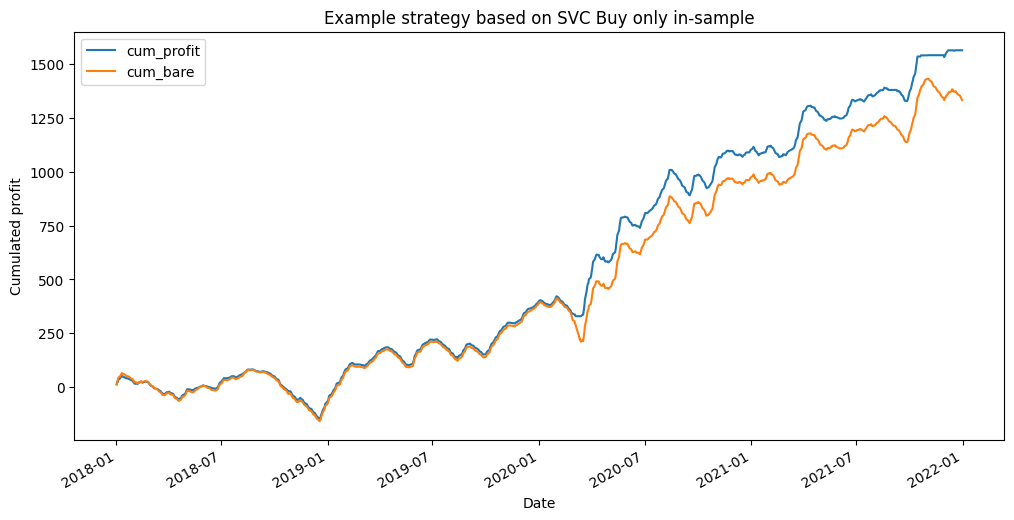

In [32]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)
strategy_df[["cum_profit", "cum_bare"]].plot(figsize=(12,6), ylabel="Cumulated profit", title="Example strategy based on SVC Buy only in-sample")
plt.legend()
plt.show()

### out-of-sample

In [33]:
strategy = []
date_idx = []
for x,i in enumerate(range(len(predictions),0,-1)):
    row = orig_df.iloc[-i,:].to_dict()
    quote_date = orig_df.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date,"EXPIRE_DATE"])
    final_price = spy.loc[exp_date,"Close"]
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]: # buy
        if final_price > strike:
            profit = final_price-(strike+call_price)
        else:
            profit = -call_price
        res = {"strategy":predictions[x], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    else:    
        res = {"strategy":predictions[x], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": 0.,
               "bare": max(final_price-(strike+call_price), -call_price)}
    strategy.append(res)
    date_idx.append(quote_date)
        
    


In [34]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))
strategy_df


,strategy,strike,call_price,exp_date,final_price,profit,bare
Date,,,,,,,
2022-01-03,0,478.0,4.81,2022-01-24,439.839996,0.00,-4.810000
2022-01-04,0,478.0,4.80,2022-01-24,439.839996,0.00,-4.800000
2022-01-05,0,468.0,8.14,2022-01-26,433.380005,0.00,-8.140000
2022-01-06,0,468.0,7.00,2022-01-26,433.380005,0.00,-7.000000
2022-01-07,0,466.0,7.56,2022-01-28,441.950012,0.00,-7.560000
...,...,...,...,...,...,...,...
2022-12-23,0,383.0,8.00,2023-01-13,398.500000,0.00,7.500000
2022-12-26,1,383.0,7.96,2023-01-13,398.500000,7.54,7.540000
2022-12-28,0,377.0,8.75,2023-01-20,395.880005,0.00,10.130005


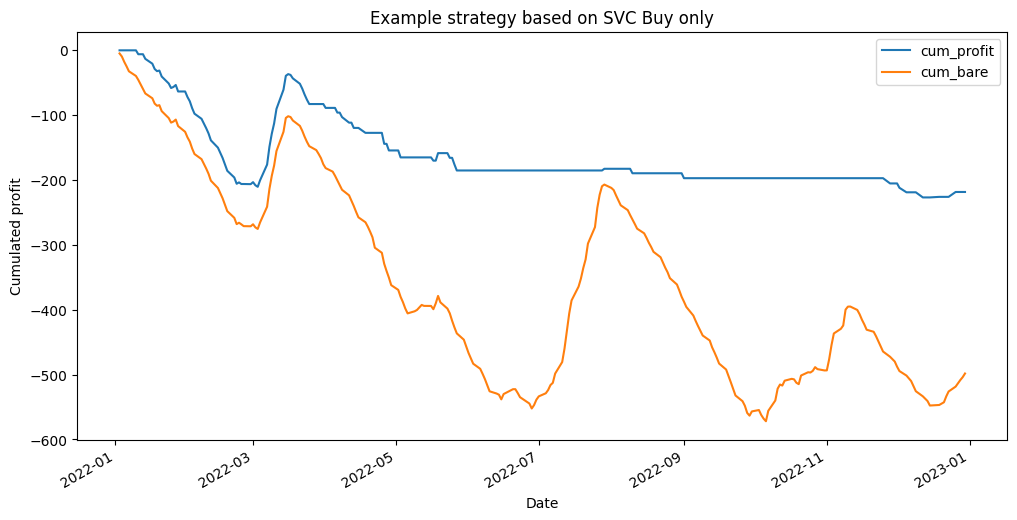

In [35]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)
strategy_df[["cum_profit", "cum_bare"]].plot(figsize=(12,6), ylabel="Cumulated profit", title="Example strategy based on SVC Buy only")
plt.legend()
plt.show()

## SVC with data from MC simulation and some addtional features

In [36]:
new_df = pd.concat((ml_df[["UNDERLYING_LAST", "STRIKE", "C_LAST", "C_BID", "C_ASK", "C_IV", "C_VOLUME", "diff"]],wk_df.drop(["last_quote", "strike"], axis=1) ), axis=1)

In [37]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"]-new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"]-new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"],2)
new_df["exp_profit"] = new_df["exp_price"]-(new_df["STRIKE"]+new_df["C_LAST"])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(new_df.values, target.values.flatten(), test_size=0.2, random_state=1968)

In [39]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('scaler', StandardScaler()),('svc', SVC())])

In [40]:
n_iter = 200
verbose_level = 1
n_jobs = 4
cv = StratifiedKFold(4)
random_grid = get_params()

In [41]:
# Grid search
rf_random = RandomizedSearchCV(estimator = pipe, 
                               param_distributions = random_grid, 
                               n_iter = n_iter, 
                               cv = cv,
                               verbose=verbose_level, 
                               random_state=1968, 
                               n_jobs = n_jobs)

In [42]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 200 candidates, totalling 800 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(fill_value=0.0,
                                                            strategy='constant')),
                                             ('scaler', StandardScaler()),
                                             ('svc', SVC())]),
                   n_iter=200, n_jobs=4,
                   param_distributions={'svc__C': array([1.00000000e-02, 1.37382380e-02, 1.88739182e-02, 2.59294380e-02,
       3.56224789e-02, 4.89...
       1.61026203e+00, 2.21221629e+00, 3.03919538e+00, 4.17531894e+00,
       5.73615251e+00, 7.88046282e+00, 1.08263673e+01, 1.48735211e+01,
       2.04335972e+01, 2.80721620e+01, 3.85662042e+01, 5.29831691e+01,
       7.27895384e+01, 1.00000000e+02]),
                                        'svc__degree': [2, 3, 4, 5, 6, 7, 8],
                                        'svc__gamma': ['auto', 'scale'],
                                        'svc__kernel': ['linear', 'poly', 'rbf',
                                                        'sigmoid'],
                                        'svc__random_state': [1968],
                                        'svc__shrinking': [True, False]},
                   random_state=1968, verbose=1)

In [43]:
rf_random.best_params_

{'svc__shrinking': True,
 'svc__random_state': 1968,
 'svc__kernel': 'rbf',
 'svc__gamma': 'scale',
 'svc__degree': 5,
 'svc__C': 52.98316906283707}

In [44]:
pd.DataFrame.from_dict(rf_random.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__shrinking,param_svc__random_state,param_svc__kernel,param_svc__gamma,param_svc__degree,param_svc__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
184,0.065843,0.001896,0.027693,0.002448,True,1968,rbf,scale,6,52.983169,"{'svc__shrinking': True, 'svc__random_state': ...",0.605578,0.633466,0.656,0.656,0.637761,0.020734,1
46,0.065345,0.005067,0.024293,0.002909,True,1968,rbf,scale,5,52.983169,"{'svc__shrinking': True, 'svc__random_state': ...",0.605578,0.633466,0.656,0.656,0.637761,0.020734,1
177,0.070818,0.004300,0.024603,0.004539,True,1968,rbf,scale,8,72.789538,"{'svc__shrinking': True, 'svc__random_state': ...",0.601594,0.629482,0.640,0.676,0.636769,0.026645,3
130,0.075719,0.007050,0.024951,0.000881,True,1968,rbf,scale,2,72.789538,"{'svc__shrinking': True, 'svc__random_state': ...",0.601594,0.629482,0.640,0.676,0.636769,0.026645,3
120,0.056013,0.002989,0.021613,0.001642,True,1968,rbf,auto,4,38.566204,"{'svc__shrinking': True, 'svc__random_state': ...",0.609562,0.621514,0.644,0.656,0.632769,0.018242,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,0.033985,0.005715,0.008461,0.001419,True,1968,sigmoid,scale,6,100.0,"{'svc__shrinking': True, 'svc__random_state': ...",0.470120,0.458167,0.484,0.420,0.458072,0.023806,193
106,0.037697,0.007472,0.008256,0.000793,False,1968,sigmoid,scale,4,100.0,"{'svc__shrinking': False, 'svc__random_state':...",0.470120,0.458167,0.484,0.420,0.458072,0.023806,193
103,0.034724,0.004745,0.009840,0.001872,True,1968,sigmoid,scale,7,28.072162,"{'svc__shrinking': True, 'svc__random_state': ...",0.470120,0.458167,0.488,0.416,0.458072,0.026509,193
12,0.042991,0.012491,0.009275,0.001437,True,1968,sigmoid,scale,4,100.0,"{'svc__shrinking': True, 'svc__random_state': ...",0.470120,0.458167,0.484,0.420,0.458072,0.023806,193


In [45]:
best_model = rf_random.best_estimator_

In [46]:
best_model.score(X_test, y_test)

0.6733067729083665

In [47]:
predictions = best_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.66      0.67      0.67       123
           1       0.68      0.67      0.68       128

    accuracy                           0.67       251
   macro avg       0.67      0.67      0.67       251
weighted avg       0.67      0.67      0.67       251



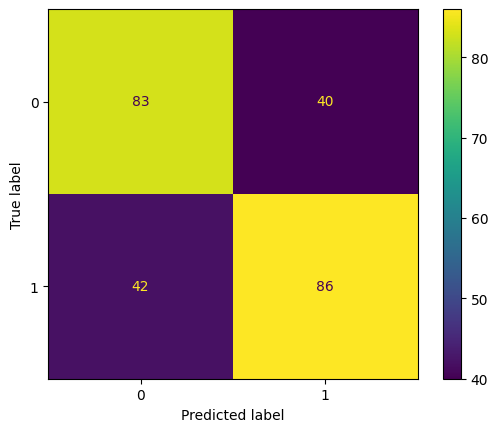

In [48]:
display_report(y_test, predictions)

### Test model

In [49]:
X_train, X_test, y_train, y_test = train_test_split(new_df.values, target.values.flatten(), test_size=0.2, random_state=1968, shuffle=False)

In [50]:
rf_params = {k[5:]:v for k,v in rf_random.best_params_.items()} | {
 'verbose':1}

In [51]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('scaler', StandardScaler()), ('svc', SVC(**rf_params))])

In [52]:
# Fit the tuned model
pipe.fit(X_train, y_train)

[LibSVM]......*...*
optimization finished, #iter = 9377
obj = -28966.055441, rho = -0.020261
nSV = 739, nBSV = 545
Total nSV = 739


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('svc',
                 SVC(C=52.98316906283707, degree=5, random_state=1968,
                     verbose=1))])

In [53]:
predictions = pipe.predict(X_test)

In [54]:
pipe.score(X_test, y_test)

0.5258964143426295

In [55]:
insample_preds = pipe.predict(X_train)

### Buy only strategy 

### in-sample

In [56]:
strategy = []
date_idx = []
prev_price = 0.0
for i in range(len(insample_preds)):
    row = new_df.iloc[i,:].to_dict()
    quote_date = new_df.index[i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date,"EXPIRE_DATE"])
    # Get price at expiration
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except:
        final_price = prev_price
    prev_price = final_price
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if insample_preds[i]: # buy
        if final_price > strike:
            profit = final_price-(strike+call_price)
        else:
            profit = -call_price
        res = {"strategy":insample_preds[i], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    else:
        if final_price > strike:
            profit = call_price
        else:
            profit = final_price-strike+call_price
        res = {"strategy":insample_preds[i], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": 0.0,
               "bare": max(final_price-(strike+call_price), -call_price)}
    strategy.append(res)
    date_idx.append(quote_date)
        
    


In [57]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))
strategy_df


,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare
Date,,,,,,,,
2018-01-02,1,269.0,1.56,4.795895,2018-01-24,283.179993,12.619993,12.619993
2018-01-03,0,270.0,2.15,4.898009,2018-01-24,283.179993,0.000000,11.029993
2018-01-04,0,272.0,1.67,4.327332,2018-01-24,283.179993,0.000000,9.509993
2018-01-05,1,273.0,2.21,4.899561,2018-01-26,286.579987,11.369987,11.369987
2018-01-08,1,274.0,2.08,4.865014,2018-01-31,281.899994,5.819994,5.819994
...,...,...,...,...,...,...,...,...
2021-12-27,0,477.0,5.76,11.573253,2022-01-18,456.489990,0.000000,-5.760000
2021-12-28,0,477.0,5.29,11.027398,2022-01-18,456.489990,0.000000,-5.290000
2021-12-29,0,478.0,5.43,10.748298,2022-01-19,451.750000,0.000000,-5.430000


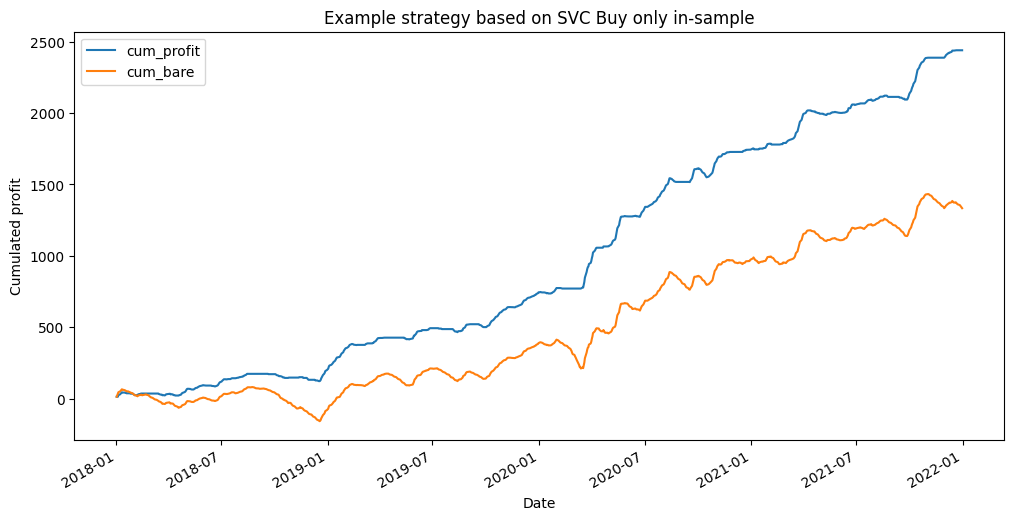

In [58]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)
strategy_df[["cum_profit", "cum_bare"]].plot(figsize=(12,6), ylabel="Cumulated profit", title="Example strategy based on SVC Buy only in-sample")
plt.legend()
plt.show()

### out-of-sample

In [59]:
strategy = []
date_idx = []
for x,i in enumerate(range(len(predictions),0,-1)):
    row = new_df.iloc[-i,:].to_dict()
    quote_date = new_df.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date,"EXPIRE_DATE"])
    final_price = spy.loc[exp_date,"Close"]
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]: # buy
        if final_price > strike:
            profit = final_price-(strike+call_price)
        else:
            profit = -call_price
        res = {"strategy":predictions[x], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    else:    
        res = {"strategy":predictions[x], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": 0.,
               "bare": max(final_price-(strike+call_price), -call_price)}
    strategy.append(res)
    date_idx.append(quote_date)
        
    


In [60]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))
strategy_df


,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare
Date,,,,,,,,
2022-01-03,0,478.0,4.81,10.248337,2022-01-24,439.839996,0.000000,-4.810000
2022-01-04,0,478.0,4.80,9.610177,2022-01-24,439.839996,0.000000,-4.800000
2022-01-05,0,468.0,8.14,10.191128,2022-01-26,433.380005,0.000000,-8.140000
2022-01-06,1,468.0,7.00,9.657596,2022-01-26,433.380005,-7.000000,-7.000000
2022-01-07,0,466.0,7.56,9.927762,2022-01-28,441.950012,0.000000,-7.560000
...,...,...,...,...,...,...,...,...
2022-12-23,0,383.0,8.00,8.453400,2023-01-13,398.500000,0.000000,7.500000
2022-12-26,0,383.0,7.96,8.096501,2023-01-13,398.500000,0.000000,7.540000
2022-12-28,0,377.0,8.75,8.526141,2023-01-20,395.880005,0.000000,10.130005


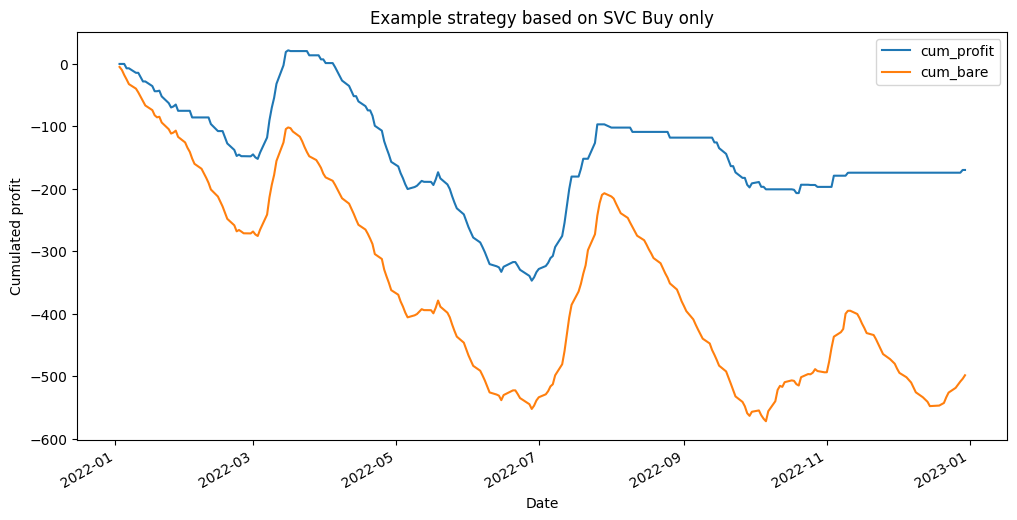

In [61]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)
strategy_df[["cum_profit", "cum_bare"]].plot(figsize=(12,6), ylabel="Cumulated profit", title="Example strategy based on SVC Buy only")
plt.legend()
plt.show()